# Linear, Polynomial, and Decision Tree Regression

In [1]:
from IPython.display import Image

import os
os.environ['CUDA_VISIBLE_DEVICES'] = "2, 3"

# inline plotting instead of popping out
%matplotlib inline

* We will guide you through the linear and polynomial regression using the Housing dataset [(description, data)](https://archive.ics.uci.edu/ml/machine-learning-databases/housing/housing.names).
* We will also extend the **Decision Tree** and **Random Forest** classifiers that we have learned from our previous labs to solve the regression problem.

# <a name='LR'>Linear Regression</a>
* Regression models are used to predict target variables (y's) in <font color='Res'>continuous space</font>, which makes them attractive for
    * Understanding relationships between variables
    * Evaluating trends
    * Making forecasts
* Consider $y$ can be explained by the 1-D points ($x∈R$), the linear model is defined as:
    * $\hat {y}=w_{0}+w_{1}x$
    * Minimizing the [sum of squared errors](#SSE) (SSE) can be understood as finding the best-fitting straight line through the example points.
    * The best-fitting line is called the regression line (or hyperplane when $x∈R^{D}, D>1$ ), and the vertical offsets from the regression line to the data points are called the residuals (i.e., the errors of our prediction).
    * Shown in the following:
    <img src='https://nthu-datalab.github.io/ml/labs/04-2_Regression/fig-linear-regression.png' width='400'></img>
    * Note that the w0 and w1 control the intercept/bias and slope of the regression line respectively.

# The Housing dataset
* The Housing dataset from UCI repository collects information about houses in the suburbs of Boston. Following are the attributes:
        1.  CRIM      Per capita crime rate by town
        2.  ZN        Proportion of residential land zoned for lots over 25,000 sq.ft.
        3.  INDUS     Proportion of non-retail business acres per town
        4.  CHAS      Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        5.  NOX       Nitric oxides concentration (parts per 10 million)
        6.  RM        Average number of rooms per dwelling
        7.  AGE       Proportion of owner-occupied units built prior to 1940
        8.  DIS       Weighted distances to five Boston employment centres
        9.  RAD       Index of accessibility to radial highways
        10. TAX       Full-value property-tax rate per \$10,000
        11. PTRATIO   Pupil-teacher ratio by town
        12. B         1000(Bk - 0.63)^2 where Bk is the proportion of blacks by town
        13. LSTAT     % lower status of the population
        14. MEDV      Median value of owner-occupied homes in $1000's
* Our goal is to predict the house prices ('MEDV'), which is in a continuous scale, using the values of some other variable. 
* Let's load the data first, and see head 5 data in dataset.

In [2]:
import pandas as pd

df = pd.read_csv(
    'https://archive.ics.uci.edu/ml/machine-learning-databases/'
    'housing/housing.data',
    header=None,
    sep='\s+')

df.columns = [
    'CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX',
    'PTRATIO', 'B', 'LSTAT', 'MEDV'
]
df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222.0,18.7,396.90,5.33,36.2


* To select proper explanatory variables, we plot all the pairwise join distributions related to 'MEDV'.
* 畫出每個feature跟MEDV的對應圖

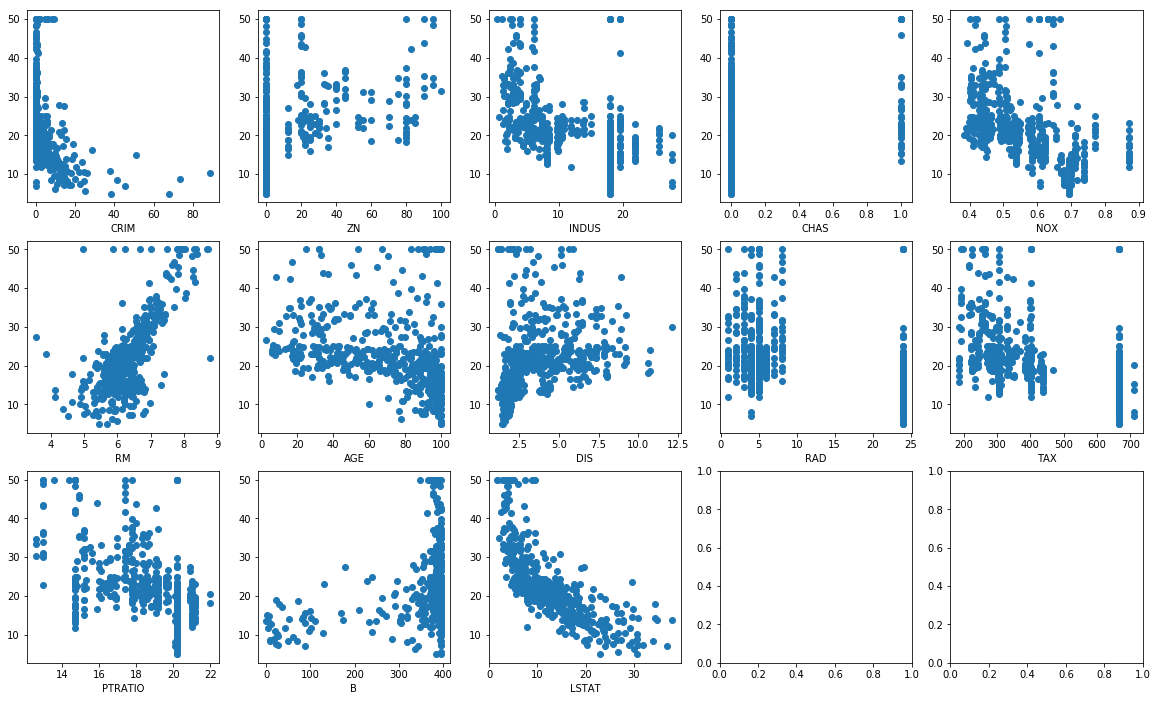

In [3]:
import matplotlib.pyplot as plt
x_vars = [
    'CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX',
    'PTRATIO', 'B', 'LSTAT'
]

_, subplot_arr = plt.subplots(3, 5, figsize=(20, 12))
for idx, x_var in enumerate(x_vars):
  x_idx = idx // 5
  y_idx = idx % 5
  subplot_arr[x_idx, y_idx].scatter(df[x_var], df['MEDV'])
  subplot_arr[x_idx, y_idx].set_xlabel(x_var)

plt.show()

* Using this scatter-plot matrix, we can now quickly see how the data is distributed and whether it contains outliers. 
* For example, we can see that there is a linear relationship between **RM and the house prices MEDV**.(最左邊往下數第二個)
* We can see in the histogram that both RM and MEDV variable seems to be normally distributed but MEDV contains several <a name='BackOutlier'>[**outliers**](#Outlier)</a>, i.e. values that deviate from the majority values a lot.
* Let's use RM as the explanatory variable for our first linear regression task:

# Fitting a Linear Regression Model via Scikit-learn
* Scikit-learn has already implemented an **LinearRegression class** that we can make use of:

In [4]:
from sklearn.linear_model import LinearRegression
import numpy as np

X_rm = df['RM'].values[:, np.newaxis]
y = df['MEDV'].values

slr = LinearRegression()
# fit 
slr.fit(X_rm, y)

y_pred = slr.predict(X_rm)

print('Slope (w_1): %.2f' % slr.coef_[0])
print('Intercept/bias (w_0): %.2f' % slr.intercept_)

Slope (w_1): 9.10
Intercept/bias (w_0): -34.67


* We may interpret the slope 9.10 as the average increase in 'MEDV' due to 'RM'. And the intercept(截距) sometimes also has physical meaning, but not in this case. Since that there is no negative value of a house
* Next, let's visualize how well the linear regression line fits the training data:

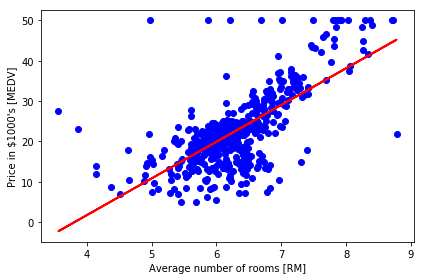

In [5]:
# To simplify our codes, predefine a function to visualize to regression line and data scatter plot.
def lin_regplot(X, y, model):
  plt.scatter(X, y, c='blue')
  plt.plot(X, model.predict(X), color='red', linewidth=2)
  return


lin_regplot(X_rm, y, slr)
plt.xlabel('Average number of rooms [RM]')
plt.ylabel('Price in $1000\'s [MEDV]')
plt.tight_layout()
plt.show()

* As we can see, the linear regression line reflects the general trend that house prices tend to increase with the number of rooms.
* We also observe a curious line at y=50 , which suggests that the prices may have been clipped.

# Multivariate Cases & Performance Evaluation
* If we have multiple explanatory variables, we can't visualize the linear regression hyperplane in a two-dimensional plot. In this case, we need some other ways to evaluate the trained model.
* Let's proceed with the multivariate linear regression and evaluate the results using the mean squared error (MSE) and coefficient of determination ($R^{2}$):
    $$MSE=\frac{1}{N}\sum_{i=1}^{N}(y^{(i)}-\hat{y}^{(i)})^{2}$$
    $$R^{2}=1-Relative Squared Error(RSE)=\frac{\sum_{i=1}^{N}(y^{(i)}-\hat{y}^{i})^{2}}{\sum_{i=1}^{N}(y^{(i)}-\bar{y})^{2}}$$

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

X = df.iloc[:, :-1].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=0)

print('#Training data points: %d' % X_train.shape[0])
print('#Testing data points: %d' % X_test.shape[0])

# Standardization

sc = StandardScaler()
sc.fit(X_train)
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)

# Training

slr = LinearRegression()
slr.fit(X_train_std, y_train)

# Testing

y_train_pred = slr.predict(X_train_std)
y_test_pred = slr.predict(X_test_std)

print('MSE train: %.2f, test: %.2f' %
      (mean_squared_error(y_train, y_train_pred),
       mean_squared_error(y_test, y_test_pred)))
print('R^2 train: %.2f, test: %.2f' % (r2_score(y_train, y_train_pred),
                                       r2_score(y_test, y_test_pred)))

#Training data points: 354
#Testing data points: 152
MSE train: 19.96, test: 27.20
R^2 train: 0.76, test: 0.67


* A normal $R^{2}$ value should fall between between 0 and 1, and the higher $R^{2}$ the better.
* In practice, we often consider $R^{2}$>0.8 as good. if $R^{2}$ is negative, it means that your model doesn't fit your data.
* <font color='Red'>NOTE</font>:
    * It is important to **standardize** the explanatory variables in multivariate regression in order to improve the conditioning of the cost function and to prevent attributes with large values from dominating.

# <a name='BackRP'>Residual Plot</a>
* The [residual plot](#RP) is a commonly used **graphical analysis for a regression model to detect nonlinearity and outliers**.
* In the case of a perfect prediction, the residuals would be exactly zero, which we will probably never encounter in realistic and practical applications.
* However, for a good regression model, we would expect that the errors are randomly distributed and the residuals should be **randomly scattered around the centerline**.
* If we see patterns in a residual plot, it means that our model is unable to capture some explanatory information, which is leaked into the residuals (as we can slightly see in the below). 
* Furthermore, we can also use residual plots to detect outliers, which are represented by the points with a large deviation from the centerline.

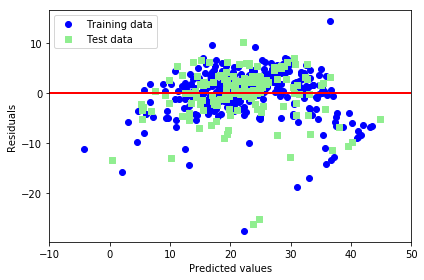

In [7]:
plt.scatter(
    y_train_pred,
    y_train_pred - y_train,
    c='blue',
    marker='o',
    label='Training data')
plt.scatter(
    y_test_pred,
    y_test_pred - y_test,
    c='lightgreen',
    marker='s',
    label='Test data')
plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.legend(loc='upper left')
plt.hlines(y=0, xmin=-10, xmax=50, lw=2, color='red')
plt.xlim([-10, 50])
plt.tight_layout()
plt.show()

# Implementing the Linear Regression
* Now, let's implement our own linear regression model. It is almost the same as the Adaline classifier we have implemented:

In [8]:
class LinearRegressionGD(object):

    def __init__(self, eta=0.001, n_iter=20, random_state=1):
        self.eta = eta
        self.n_iter = n_iter
        self.random_state = random_state

    def fit(self, X, y):
        rgen = np.random.RandomState(self.random_state)
        self.w_ = rgen.normal(loc=0.0, scale=0.01, size=1 + X.shape[1])
        self.cost_ = []

        for i in range(self.n_iter):
          output = self.net_input(X)
          errors = (y - output)
          self.w_[1:] += self.eta * X.T.dot(errors)
          self.w_[0] += self.eta * errors.sum()
          cost = (errors**2).sum() / 2.0
          self.cost_.append(cost)
        return self

    def net_input(self, X):
        return np.dot(X, self.w_[1:]) + self.w_[0]

    def predict(self, X):
        return self.net_input(X)

* It is always a good practice to plot the cost as a function of the number of epochs (passes over the training dataset) when we are using optimization algorithms, such as gradient descent, to check for the convergence:

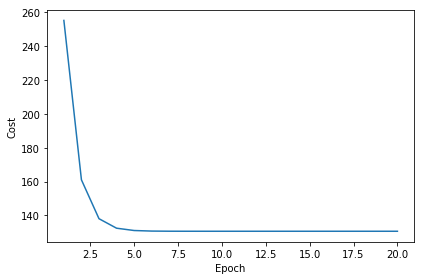

In [9]:
from sklearn.preprocessing import StandardScaler

sc_x = StandardScaler()
sc_y = StandardScaler()
X_rm_std = sc_x.fit_transform(X_rm)
y_std = sc_y.fit_transform(y[:, np.newaxis]).flatten()

lr = LinearRegressionGD()
lr.fit(X_rm_std, y_std)

plt.plot(range(1, lr.n_iter + 1), lr.cost_)
plt.ylabel('Cost')
plt.xlabel('Epoch')
plt.tight_layout()
plt.show()

* Next, let's visualize how well the linear regression line fits the training data:

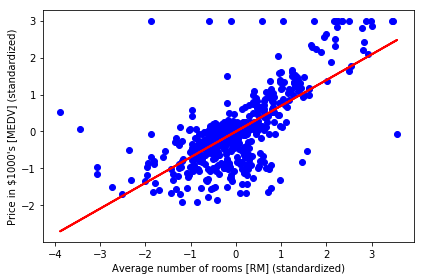

In [10]:
lin_regplot(X_rm_std, y_std, lr)
plt.xlabel('Average number of rooms [RM] (standardized)')
plt.ylabel('Price in $1000\'s [MEDV] (standardized)')
plt.tight_layout()
plt.show()

* We can see that the overall result looks almost identical to the Scikit-learn implementation.
* Note: However, that the implementation in Scikit-learn makes use of the LIBLINEAR library and advanced optimization algorithms that work better with unstandardized variables.

# <a name='PR'>Polynomial Regression</a>
* Linear regression assumes a linear relationship between explanatory and response variables, which may not hold in the real world. 
* For example, by seeing the pairwise distribution plot again, we find that the LSTAT (% lower status of the population) attribute is clearly not linearly correlated with our target variable MEDV. 
* More information about [PolynomialFeatures](#PF)
* Next, let's construct polynomial features and turn our linear regression models into the polynomial ones.

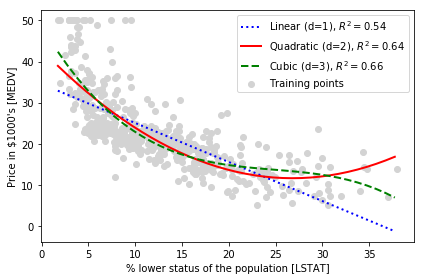

In [11]:
from sklearn.preprocessing import PolynomialFeatures

X_lin = df['LSTAT'].values[:, np.newaxis]

regr = LinearRegression()

# Create quadratic features
quadratic = PolynomialFeatures(degree=2)
cubic = PolynomialFeatures(degree=3)
X_quad = quadratic.fit_transform(X_lin)
X_cubic = cubic.fit_transform(X_lin)

# fit features
lin_regr = LinearRegression()
lin_regr.fit(X_lin, y)
linear_r2 = r2_score(y, lin_regr.predict(X_lin))

quad_regr = LinearRegression()
quad_regr.fit(X_quad, y)
quadratic_r2 = r2_score(y, quad_regr.predict(X_quad))

cubic_regr = LinearRegression()
cubic_regr.fit(X_cubic, y)
cubic_r2 = r2_score(y, cubic_regr.predict(X_cubic))

# plot results
X_range = np.arange(X_lin.min(), X_lin.max(), 1)[:, np.newaxis]
y_lin_pred = lin_regr.predict(X_range)
y_quad_pred = quad_regr.predict(quadratic.fit_transform(X_range))
y_cubic_pred = cubic_regr.predict(cubic.fit_transform(X_range))

plt.scatter(X_lin, y, label='Training points', color='lightgray')

plt.plot(
    X_range,
    y_lin_pred,
    label='Linear (d=1), $R^2=%.2f$' % linear_r2,
    color='blue',
    lw=2,
    linestyle=':')

plt.plot(
    X_range,
    y_quad_pred,
    label='Quadratic (d=2), $R^2=%.2f$' % quadratic_r2,
    color='red',
    lw=2,
    linestyle='-')

plt.plot(
    X_range,
    y_cubic_pred,
    label='Cubic (d=3), $R^2=%.2f$' % cubic_r2,
    color='green',
    lw=2,
    linestyle='--')

plt.xlabel('% lower status of the population [LSTAT]')
plt.ylabel('Price in $1000\'s [MEDV]')
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()

* In the resulting plot, we can see that the polynomial fit captures the relationship between the response and explanatory variable much better than the linear fit.

# Multivariate Cases
* Next, we train polynomial regressors of different degrees using all features in the Housing dataset and compare their performance.

In [12]:
regr = LinearRegression()

print('[Linear]')
print('#Features: %d' % X_train_std.shape[1])
regr = regr.fit(X_train_std, y_train)
y_train_pred = regr.predict(X_train_std)
y_test_pred = regr.predict(X_test_std)
print('MSE train: %.2f, test: %.2f' %
      (mean_squared_error(y_train, y_train_pred),
       mean_squared_error(y_test, y_test_pred)))
print('R^2 train: %.2f, test: %.2f' % (r2_score(y_train, y_train_pred),
                                       r2_score(y_test, y_test_pred)))

print('\n[Quadratic]')
X_quad_train = quadratic.fit_transform(X_train_std)
X_quad_test = quadratic.fit_transform(X_test_std)
print('#Features: %d' % X_quad_train.shape[1])
regr = regr.fit(X_quad_train, y_train)
y_train_pred = regr.predict(X_quad_train)
y_test_pred = regr.predict(X_quad_test)
print('MSE train: %.2f, test: %.2f' %
      (mean_squared_error(y_train, y_train_pred),
       mean_squared_error(y_test, y_test_pred)))
print('R^2 train: %.2f, test: %.2f' % (r2_score(y_train, y_train_pred),
                                       r2_score(y_test, y_test_pred)))

print('\n[Cubic]')
X_cubic_train = cubic.fit_transform(X_train_std)
X_cubic_test = cubic.fit_transform(X_test_std)
print('#Features: %d' % X_cubic_train.shape[1])
regr = regr.fit(X_cubic_train, y_train)
y_train_pred = regr.predict(X_cubic_train)
y_test_pred = regr.predict(X_cubic_test)
print('MSE train: %.2f, test: %.2f' %
      (mean_squared_error(y_train, y_train_pred),
       mean_squared_error(y_test, y_test_pred)))
print('R^2 train: %.2f, test: %.2f' % (r2_score(y_train, y_train_pred),
                                       r2_score(y_test, y_test_pred)))

[Linear]
#Features: 13
MSE train: 19.96, test: 27.20
R^2 train: 0.76, test: 0.67

[Quadratic]
#Features: 105
MSE train: 4.10, test: 29.43
R^2 train: 0.95, test: 0.65

[Cubic]
#Features: 560
MSE train: 0.00, test: 21611.28
R^2 train: 1.00, test: -258.55


* As the degree of polynomial goes up, the training errors decrease, **but not the testing errors**.
* That is, **a low training error does not implies a low ~~training~~ testing error**. We will discuss this further in our next lecture.

# Decision Tree Regression
* Polynomial regression is not the only way to capture the nonlinear relationship between the explanatory and target variables.
* For example, we can modify the Decision Tree model for non-linear regression by simply replacing the entropy as the impurity measure of a node by the MSE.
* Let's see how it works in our task:

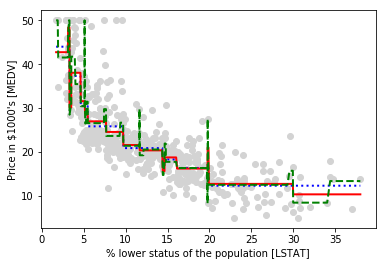

In [13]:
from sklearn.tree import DecisionTreeRegressor

tree_3 = DecisionTreeRegressor(max_depth=3)
tree_3.fit(X_lin, y)
tree_4 = DecisionTreeRegressor(max_depth=4)
tree_4.fit(X_lin, y)
tree_5 = DecisionTreeRegressor(max_depth=5)
tree_5.fit(X_lin, y)

sort_idx = X_lin.flatten().argsort()

plt.scatter(X_lin, y, color='lightgray')

plt.plot(
    X_lin[sort_idx],
    tree_3.predict(X_lin)[sort_idx],
    color='blue',
    lw=2,
    linestyle=':')
plt.plot(
    X_lin[sort_idx],
    tree_4.predict(X_lin)[sort_idx],
    color='red',
    lw=2,
    linestyle='-')

plt.plot(
    X_lin[sort_idx],
    tree_5.predict(X_lin)[sort_idx],
    color='green',
    lw=2,
    linestyle='--')

plt.xlabel('% lower status of the population [LSTAT]')
plt.ylabel('Price in $1000\'s [MEDV]')
plt.show()

* As we can see from the resulting plot, the decision tree captures the general trend in the data.
* However, a limitation of this model is that it does not capture the continuity and differentiability of the desired prediction.

# Random Forest Regression
* We can also modify the Random Forest model for regression to take advantages of an ensemble technique and get a better generalization performance.
* The basic random forests algorithm for regression is almost identical to the random forest algorithm for classification.
* The only difference is that we use the MSE criterion to grow individual decision trees, and the predicted target variable is calculated as the average prediction over all decision trees. 
* Now, let's use all the features in the Housing dataset to train a random forest regression model:

MSE train: 1.41, test: 14.36
R^2 train: 0.98, test: 0.83


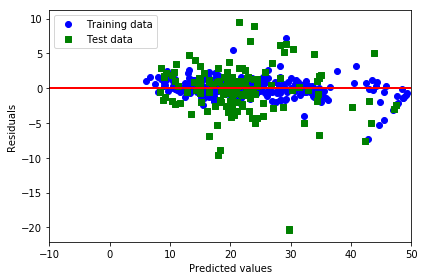

In [14]:
from sklearn.ensemble import RandomForestRegressor

forest = RandomForestRegressor(
    n_estimators=1000, criterion='mse', random_state=1, n_jobs=-1)
forest.fit(X_train, y_train)
y_train_pred = forest.predict(X_train)
y_test_pred = forest.predict(X_test)

print('MSE train: %.2f, test: %.2f' %
      (mean_squared_error(y_train, y_train_pred),
       mean_squared_error(y_test, y_test_pred)))
print('R^2 train: %.2f, test: %.2f' % (r2_score(y_train, y_train_pred),
                                       r2_score(y_test, y_test_pred)))

# Residual plot
plt.scatter(
    y_train_pred,
    y_train_pred - y_train,
    c='blue',
    marker='o',
    label='Training data')
plt.scatter(
    y_test_pred, y_test_pred - y_test, c='green', marker='s', label='Test data')

plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.legend(loc='upper left')
plt.hlines(y=0, xmin=-10, xmax=50, lw=2, color='red')
plt.xlim([-10, 50])
plt.tight_layout()
plt.show()

* We get better testing results ($R2=0.83$) than those of multivariate linear regression ($R2=0.67$) and see weaker patterns in the residual plot. 
* However, we still observe that the testing performance is much worse than the training one. 

* <font color='Red'>NOTE:</font> 
    * As in the classification, Decision Tree and Random Forest regression has a nice feature that they are not sensitive to the scaling of each explanatory variable. So we do **not standardize features** this time.

# <a name='remark'>Remarks</a>
1. Regression models are basically [interpolation](#interpolation) equations over the range of the explanatory variables. So they may give bad predictions if we extrapolate outside this range.
2. Be careful about the outliers, which may change your regression hyperplane undesirably.
* (簡單說就是model有去fit training data的感覺，導致testing data沒那麼好)

# Assignmant
* In this assignment, you need to train regression models on [Beijing PM2.5 dataset](http://archive.ics.uci.edu/ml/datasets/Beijing+PM2.5+Data) in winter of 2014
    1. You have to implement
        * a Linear(Polynomial) regressor
        * a Random Forest regressor
    2. You need to show a residual plot for each of your model on both training data and testing data.
    3. $R^{2}$ score need to be larger than 0.72 on testing data.

In [15]:
# Do not modify
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Image

# inline plotting instead of popping out
%matplotlib inline

df = pd.read_csv(
    'http://archive.ics.uci.edu/ml/machine-learning-databases/00381/PRSA_data_2010.1.1-2014.12.31.csv',
    sep=',')
df.head()

,No,year,month,day,hour,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir
0,1,2010,1,1,0,NaN,-21,-11.0,1021.0,NW,1.79,0,0
1,2,2010,1,1,1,NaN,-21,-12.0,1020.0,NW,4.92,0,0
2,3,2010,1,1,2,NaN,-21,-11.0,1019.0,NW,6.71,0,0
3,4,2010,1,1,3,NaN,-21,-14.0,1019.0,NW,9.84,0,0
4,5,2010,1,1,4,NaN,-20,-12.0,1018.0,NW,12.97,0,0


* In the following, we select data that are recorded in winter between 2013 and 2014.
* In the latter course, we will teach how to deal with those sample whose has nan (not a number) or non-scalar features. For now, we just remove them.

In [16]:
# Do not modify
df = df.drop(['cbwd'], axis=1)  # drop non-scalar feature
df = df.dropna(axis=0, how='any')  # drop samples who has nan feature
df.head()

,No,year,month,day,hour,pm2.5,DEWP,TEMP,PRES,Iws,Is,Ir
24,25,2010,1,2,0,129.0,-16,-4.0,1020.0,1.79,0,0
25,26,2010,1,2,1,148.0,-15,-4.0,1020.0,2.68,0,0
26,27,2010,1,2,2,159.0,-11,-5.0,1021.0,3.57,0,0
27,28,2010,1,2,3,181.0,-7,-5.0,1022.0,5.36,1,0
28,29,2010,1,2,4,138.0,-7,-5.0,1022.0,6.25,2,0


In [17]:
# Do not modify
idx = np.logical_or(
    np.logical_and(df['year'].values == 2014, df['month'].values < 3),
    np.logical_and(df['year'].values == 2013, df['month'].values == 12))
X = df.loc[idx].drop('pm2.5', axis=1)
y = df.loc[idx]['pm2.5'].values
X.head()

,No,year,month,day,hour,DEWP,TEMP,PRES,Iws,Is,Ir
34320,34321,2013,12,1,0,-13,-2.0,1026.0,0.89,0,0
34321,34322,2013,12,1,1,-14,-3.0,1025.0,3.13,0,0
34322,34323,2013,12,1,2,-13,-3.0,1025.0,0.89,0,0
34323,34324,2013,12,1,3,-13,-4.0,1025.0,0.89,0,0
34324,34325,2013,12,1,4,-13,-3.0,1025.0,1.78,0,0


# Random Forest regressor

In [18]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=0)
# Standardization

sc = StandardScaler()
sc_y = StandardScaler()
X_train_std = sc.fit_transform(X_train)
X_test_std = sc.transform(X_test)

/home/epl002/DL/env-name/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/home/epl002/DL/env-name/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/home/epl002/DL/env-name/lib/python3.5/site-packages/ipykernel_launcher.py:13: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  del sys.path[0]


In [19]:
from sklearn.ensemble import RandomForestRegressor

forest = RandomForestRegressor(
    n_estimators=1000, criterion='mse', random_state=1, n_jobs=-1)
forest.fit(X_train_std, y_train)

y_train_pred = forest.predict(X_train_std)
y_test_pred = forest.predict(X_test_std)

print('R^2 train: %.2f, test: %.2f' % (r2_score(y_train, y_train_pred),
                                       r2_score(y_test, y_test_pred)))

R^2 train: 0.99, test: 0.90


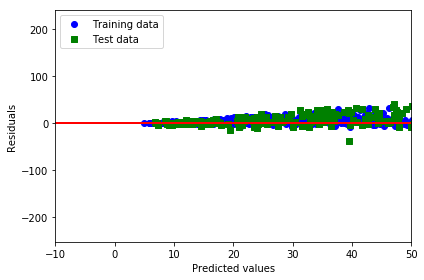

In [20]:
# Residual plot
plt.scatter(
    y_train_pred,
    y_train_pred - y_train,
    c='blue',
    marker='o',
    label='Training data')
plt.scatter(
    y_test_pred, y_test_pred - y_test, c='green', marker='s', label='Test data')

plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.legend(loc='upper left')
plt.hlines(y=0, xmin=-10, xmax=50, lw=2, color='red')
plt.xlim([-10, 50])
plt.tight_layout()
plt.show()

# Linear(Polynomial) regressor

* <font color='Red'>NOTE:</font>
    * Tune learning
    * Tune iteration
    * Feature extration 
    * Change the dimension of PolynomialFeatures function

In [21]:
class LinearRegressionGD(object):

    def __init__(self, eta=0.0000000115, n_iter=4000000, random_state=1):
        self.eta = eta
        self.n_iter = n_iter
        self.random_state = random_state

    def fit(self, X, y):
        rgen = np.random.RandomState(self.random_state)
        self.w_ = rgen.normal(loc=0.0, scale=0.01, size=1 + X.shape[1])
        self.cost_ = []
        for i in range(self.n_iter):
            output = self.net_input(X)
            errors = (y - output)
            self.w_[1:] += self.eta * X.T.dot(errors)
            self.w_[0] += self.eta * errors.sum()
            cost = (errors**2).sum() / 2.0
            self.cost_.append(cost)
        return self

    def net_input(self, X):
        return np.dot(X, self.w_[1:]) + self.w_[0]

    def predict(self, X):
        return self.net_input(X)

In [22]:
importances = forest.feature_importances_
# get sort indices in descending order
indices = np.argsort(importances)[::-1]

In [23]:
for f in range(X_train.shape[1]):
    print("%2d) %-*s %f" % (f + 1, 30, 
                            X.columns.values[indices[f]], 
                            importances[indices[f]]))

 1) DEWP                           0.460799
 2) No                             0.233257
 3) day                            0.130054
 4) PRES                           0.052546
 5) Iws                            0.050156
 6) TEMP                           0.032446
 7) hour                           0.029527
 8) month                          0.008861
 9) year                           0.001695
10) Is                             0.000422
11) Ir                             0.000238


In [24]:
X = X.drop('Is', axis=1)
X = X.drop('Ir', axis=1)

In [25]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=0)

# Standardization

sc = StandardScaler()
sc_y = StandardScaler()
X_train_std = sc.fit_transform(X_train)
X_test_std = sc.transform(X_test)

/home/epl002/DL/env-name/lib/python3.5/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/home/epl002/DL/env-name/lib/python3.5/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/home/epl002/DL/env-name/lib/python3.5/site-packages/ipykernel_launcher.py:9: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  if __name__ == '__main__':


* 需要長時間的等待，Be patient

In [26]:
regr = LinearRegressionGD()

cubic = PolynomialFeatures(degree=4)
X_cubic = cubic.fit_transform(X_train_std)

print('\n[degree=4]')
X_cubic_train = cubic.fit_transform(X_train_std)
X_cubic_test = cubic.fit_transform(X_test_std)
regr = regr.fit(X_cubic_train, y_train)
y_train_pred = regr.predict(X_cubic_train)
y_test_pred = regr.predict(X_cubic_test)
print('R^2 train: %.2f, test: %.2f' % (r2_score(y_train, y_train_pred),
                                       r2_score(y_test, y_test_pred)))


[degree=4]
R^2 train: 0.84, test: 0.79


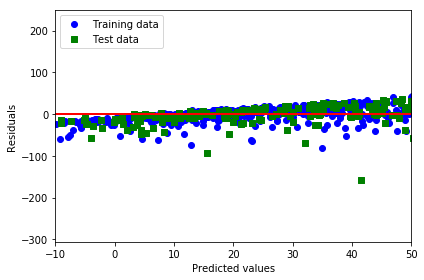

In [27]:
# Residual plot
plt.scatter(
    y_train_pred,
    y_train_pred - y_train,
    c='blue',
    marker='o',
    label='Training data')
plt.scatter(
    y_test_pred, y_test_pred - y_test, c='green', marker='s', label='Test data')

plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.legend(loc='upper left')
plt.hlines(y=0, xmin=-10, xmax=50, lw=2, color='red')
plt.xlim([-10, 50])
plt.tight_layout()
plt.show()

# <a name='SSE'>Sum of squared errors (SSE)</a>
* 簡單講就是觀察值$y$跟$\hat{y} (=a+bx)$之間的差，也就是殘差平方和
    $$SSE = \sum_{i=1}^{n}{(y_{i}-\hat{y_{i}})}$$
* [Reference](https://en.wikipedia.org/wiki/Residual_sum_of_squares)
* [Go to Linear Regression](#LR)

# <a name='outlier'>Outlier</a>
* 稱異常值，是指其資料顯著地別於其它的資料物件，且它是因為不同的機制所產生的
* 有時我們把outlier稱為abnormal data，但並非所有的outlier都要排除
* 例如在信用卡詐騙偵測(credit card fraud detection)的分析上，客戶的abnormal行為就是分析上重要的特點
* 異常值(Outlier)可大致分為三大類
    * Global outlier:
        * 是指該資料有顯著地別於其它的資料集合，大多數的outlier detection都是在於尋找這類的異常值
    * Contextual outlier
        * contextual outlier需根據資料的特定內容(contex)來進行分析
        * 例如:"今天的溫度是38度"需看這是在什麼'時間'及'地點'才能決定是否為異常值
    * Collective outlier
        * 個別的資料並沒有異常，但如果這些資料都發生在特定的子集合上時，則可能為異常
        * 異常偵測上，我們也需要了解背景資料，才能有效分析
        * 例如:"每個月缺料10次"也許不是異常值，但如果這10次缺料都發生在同一天，這就是很明顯的異常了
* [Reference](http://arthur0615.pixnet.net/blog/post/91841705-%E4%BB%80%E9%BA%BC%E6%98%AFoutlier%3F)
* [Go to Outlier](#BackOutlier)

# <a name='PF'>PolynomialFeatures</a>
* Parameters:
    * degree : integer
        * The degree of the polynomial features. Default = 2.
        * degree的vlaue = 你需要幾次式的函數
        * 例如: degree=2，2次函數
    * interaction_only : boolean, default = False
        * If true, only interaction features are produced: features that are products of at most degree distinct input features (so not x[1] ** 2, x[0] * x[2] ** 3, etc.).
        * 簡單說如果為True就不會有自己的次方項，如x平方、三次方等
    * include_bias : boolean
        * If True (default), then include a bias column, the feature in which all polynomial powers are zero (i.e. a column of ones - acts as an intercept term in a linear model).
        * 若為True，則會有常數項
* Attributes:
    * powers_ : array, shape (n_output_features, n_input_features)
        * powers_[i, j] is the exponent of the jth input in the ith output.
        * n_input_features_ : (int) The total number of input features.輸入的特徵個數
        * n_output_features_ : (int) The total number of polynomial output features. The number of output features is computed by iterating over all suitably sized combinations of input features. 
* [Reference](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PolynomialFeatures.html)
* [Polynomial Regression](#PR)

# <a name='interpolation'>Interpolation</a>
* 又稱「內插」
* 找一個函數，完全符合手邊的一堆數據。此函數稱作「內插函數」。
* 換句話說，找到一個函數，穿過所有給定的函數點。外觀就像是在相鄰的函數點之間，插滿函數點
* [Reference](http://www.csie.ntnu.edu.tw/~u91029/Interpolation.html)
* [Go to Remarks](#remark)

# <a name='RP'>Residual Plot</a>
* 稱殘差圖，來估計觀察或預測到的誤差error(殘差residuals)與隨機誤差(stochastic error)是否一致
* 例如: 丟一個骰子，當你丟出去一個六面的骰子時，你不應該能夠預測得到哪面點數是向上的。然而，你卻可以評估在一系列投擲後，正面向上的數字是否遵循一個隨機模式，心中就會想象出一個隨機散佈的殘差圖
* 假如有人背著你對骰子做了點手腳，讓六點更頻繁的出現向上，這時你心中的殘差圖看上去就似乎有規律可循，從而不得不修改心中的模型，讓你狐疑骰子一定有問題
* 相同的原則也適用於迴歸模型。你不應該能夠預測任何給定的觀察或預測結果，你需要確定殘差是否與隨機誤差相互呈現一致性，就像丟骰子一樣，殘差若整體呈現“很古怪”的模式，你就需要回頭修改你的迴歸模型了
* 殘差不應該成片的很高或很低，而是在擬合值的範圍內，殘差應該以0為中心。換句話説，模型的擬合應該平均散佈在被擬合值點附近。而且，在OLS理論中，假設隨機誤差產生的是正態分佈的殘差。因此，殘差應該是以對稱的模式，並且在整個擬合範圍內具有恆定均勻的擴散
* 例如:
<img src='https://mmbiz.qpic.cn/mmbiz_png/yUJQdJT8rHIicOFonodKicFdqj7SEPwjeI7fN8icficuew9UVsibRvzbBTHxFSrbk80ZvFl8JAgNb9rZQXUQpxxkCiag/0?' width='500'></img>
* 殘差不應該包含任何可預測的信息，例如:
<img src='https://mmbiz.qpic.cn/mmbiz_png/yUJQdJT8rHIicOFonodKicFdqj7SEPwjeI09TH1d0KwwJdfibWiavKibqwbqUDt4H8Hs3f5ANxbX7lhmWricf3UPHfvg/0?' width='500'></img>
* 上圖中，你就可以根據擬合值來預測殘差的非零值，正確殘差圖不僅要體現出隨機性(random)，還要體現不可預測性(unpredictable)
* [Reference](https://hk.saowen.com/a/7a9018ba05d692423f799f7fd5e129b49323e1a1a88c78cb55f1d7ee8700acc6)
* [Go to Residual Plot](#BackRP)